<a href="https://colab.research.google.com/github/invest41/Data_Science_Nigeria/blob/main/DSN_Hack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

– *This is a notebook detailing the necessary code for predictive analysis on Insurance Claim data, using regressive supervised machine learning models.*

##**Setting Up Environment**

In [ ]:
from math import sqrt
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
 
from sklearn.preprocessing import PolynomialFeatures as PF, StandardScaler as SSC, LabelEncoder as LE, MinMaxScaler as MMS
 
from sklearn.linear_model import LinearRegression as LR
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor as RFR, GradientBoostingRegressor as GBR
from xgboost import XGBRegressor as XGB
import xgboost as xgb
 
from sklearn.model_selection import train_test_split as TTS
 
from pandas_profiling import ProfileReport
from sklearn.metrics import mean_squared_error as MSE
 
import datetime as dt
import warnings
warnings.simplefilter('ignore')

In [ ]:
!pip install kaggle

##**Accessing Dataset**

In [ ]:
 import os, time
 
tick = time.time()
#os.environ['KAGGLE_USERNAME'] = "Generate your Kaggle API"
#os.environ['KAGGLE_KEY'] = "Generate your Kaggle API"
 
#!kaggle competitions download -c data-science-nigeria-insurance-claims-competition
print(f'\nTime taken: {time.time()-tick}')

  0% 0.00/5.65k [00:00<?, ?B/s]
100% 5.65k/5.65k [00:00<00:00, 12.0MB/s]
  0% 0.00/181k [00:00<?, ?B/s]
100% 181k/181k [00:00<00:00, 48.7MB/s]
  0% 0.00/75.1k [00:00<?, ?B/s]
100% 75.1k/75.1k [00:00<00:00, 81.4MB/s]

Time taken: 5.644144535064697


In [ ]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
sample = pd.read_csv("/content/sample_submission.csv")

##**Data Exploration**

In [ ]:
train.shape

(700, 37)

In [ ]:
train.describe()

,months_as_customer,age,capital-gains,capital-loss,policy_number,policy_deductable,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,policy_annual_premium,umbrella_limit,insured_zip,witnesses,auto_year,_c39,total_claim_amount
count,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,7.000000e+02,700.000000,700.000000,700.000000,0.0,700.000000
mean,209.528571,39.417143,25777.571429,-27061.000000,551898.977143,1142.142857,11.747143,1.827143,1.001429,1256.950357,1.092857e+06,500211.260000,1.442857,2004.984286,NaN,71900.933214
std,114.746174,9.170472,28239.300780,27874.242557,260076.772911,617.005999,6.987445,1.014970,0.819119,249.616802,2.289793e+06,71731.677629,1.132631,6.013198,NaN,34915.974923
min,0.000000,19.000000,0.000000,-111100.000000,100804.000000,500.000000,0.000000,1.000000,0.000000,433.330000,0.000000e+00,430104.000000,0.000000,1995.000000,NaN,133.330000
25%,123.000000,32.000000,0.000000,-51825.000000,337547.250000,500.000000,6.000000,1.000000,0.000000,1084.702500,0.000000e+00,446952.000000,0.000000,2000.000000,NaN,58933.330000
50%,209.000000,39.000000,5000.000000,-27450.000000,547773.000000,1000.000000,12.000000,1.000000,1.000000,1256.340000,0.000000e+00,465565.000000,1.000000,2005.000000,NaN,77733.330000
75%,283.000000,45.000000,52200.000000,0.000000,775554.500000,2000.000000,17.250000,3.000000,2.000000,1423.890000,0.000000e+00,603417.500000,2.000000,2010.000000,NaN,95503.332500
max,479.000000,64.000000,98800.000000,0.000000,998865.000000,2000.000000,23.000000,4.000000,2.000000,2047.590000,1.000000e+07,620869.000000,3.000000,2015.000000,NaN,153226.670000


In [ ]:
train.sample(3)

,Customer_ID,months_as_customer,age,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,policy_annual_premium,umbrella_limit,insured_zip,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,witnesses,police_report_available,auto_make,auto_model,auto_year,_c39,total_claim_amount
215,Customer_758,436,60,MALE,High School,prof-specialty,bungie-jumping,wife,67600,-65300,910604,1992-04-14,IN,250/500,500,7819 2nd Ave,16,1,NO,0,1362.31,0,446606,2015-01-13,Single Vehicle Collision,Front Collision,Minor Damage,Ambulance,VA,Arlington,2,NO,Saab,93,2005,NaN,109413.33
329,Customer_515,284,48,FEMALE,JD,tech-support,movies,other-relative,0,-42400,168260,1991-03-01,OH,250/500,1000,3660 Andromedia Hwy,11,1,?,0,1168.80,0,444232,2015-02-28,Single Vehicle Collision,Side Collision,Total Loss,Other,NY,Northbrook,3,YES,Mercedes,E400,2001,NaN,47666.67
177,Customer_933,36,37,FEMALE,Masters,machine-op-inspct,reading,husband,0,-59800,291902,2013-11-06,IL,500/1000,1000,2697 Oak Drive,20,3,YES,1,1115.81,0,618926,2015-02-12,Multi-vehicle Collision,Side Collision,Minor Damage,Ambulance,NY,Columbus,3,?,Dodge,Neon,2008,NaN,65040.00


In [ ]:
train['insured_sex'].value_counts().plot(kind='bar',color='green')

In [ ]:
train['age'].plot(kind='hist')

In [ ]:
train['total_claim_amount'].plot(kind='hist',
                                 bins=100)



In [ ]:
col = train.columns
#for i in col: print(train[i].value_counts(),end='\n\n\n')

In [ ]:
print(f'Number of Columns: {len(train.columns)}')

Number of Columns: 37


####**Data Processing and Cleaning**

In [ ]:
correct = ['insured_sex','insured_education_level','insured_occupation','insured_hobbies','insured_relationship',
       'policy_state','policy_csl','property_damage','incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_state', 'incident_city', 'police_report_available','auto_make', 'auto_model'
       ]

In [ ]:
#preprocessing
special = ['policy_bind_date', 'incident_date', 'incident_location']
drp = ['Customer_ID', '_c39','total_claim_amount']
 
 
ox1 = train.drop(columns=drp, axis=1)
ox2 = test.drop(columns=drp[:-1], axis=1)
 
correct.append(special[-1])
encode = LE()
for c in correct:
  ox1[c] = encode.fit_transform(ox1[c])
  ox2[c] = encode.fit_transform(ox2[c])

for i in special[:-1]:
  ox1[i] = pd.to_datetime(ox1[i])
  ox1[i] = ox1[i].map(dt.datetime.toordinal)

  ox2[i] = pd.to_datetime(ox2[i])
  ox2[i] = ox2[i].map(dt.datetime.toordinal) 
 
dx1 = pd.get_dummies(ox1)
dx2 = pd.get_dummies(ox2)
 
 
oy1 = train['total_claim_amount']

In [ ]:
ox1.head()

,months_as_customer,age,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,policy_annual_premium,umbrella_limit,insured_zip,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,witnesses,police_report_available,auto_make,auto_model,auto_year
0,239,41,0,3,4,13,2,51400,-6300,743092,639,2,1,1000,412,22,1,0,0,1325.44,7000000,474898,48,1,0,3,4,0,0,2,2,8,12,2013
1,108,31,1,5,10,19,1,0,0,492224,444,1,2,2000,366,14,1,1,0,1175.70,0,608767,49,2,2,2,1,1,1,2,1,4,27,2006
2,116,30,1,3,5,9,1,0,-35500,996253,334,1,2,500,21,8,3,1,0,951.46,0,467227,30,0,1,0,3,6,5,3,0,13,28,2004
3,8,21,1,2,5,10,0,0,0,355085,610,1,2,500,402,21,1,0,0,1021.90,0,464237,35,2,1,0,3,6,1,0,0,12,11,2012
4,161,38,1,6,8,8,1,60200,0,192524,392,0,0,2000,99,0,3,2,2,1133.85,0,439870,2,0,1,2,4,6,6,2,2,13,20,2003


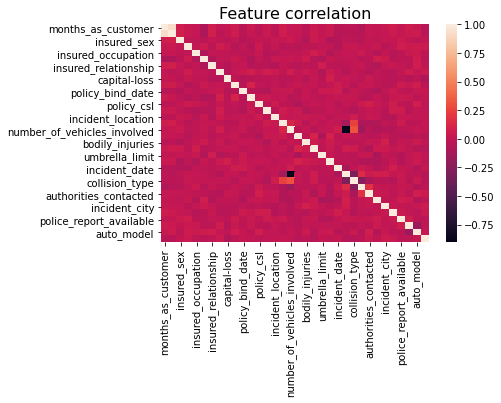

<Figure size 1152x432 with 0 Axes>

In [ ]:
%matplotlib inline
 
plt.title('Training Feature correlation',fontsize=16)
sns.heatmap(dx1.corr())
plt.figure(figsize=(16,6))
plt.show()

In [ ]:
ox1.head()

,months_as_customer,age,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,policy_annual_premium,umbrella_limit,insured_zip,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,witnesses,police_report_available,auto_make,auto_model,auto_year
0,239,41,0,3,4,13,2,51400,-6300,743092,639,2,1,1000,412,22,1,0,0,1325.44,7000000,474898,48,1,0,3,4,0,0,2,2,8,12,2013
1,108,31,1,5,10,19,1,0,0,492224,444,1,2,2000,366,14,1,1,0,1175.70,0,608767,49,2,2,2,1,1,1,2,1,4,27,2006
2,116,30,1,3,5,9,1,0,-35500,996253,334,1,2,500,21,8,3,1,0,951.46,0,467227,30,0,1,0,3,6,5,3,0,13,28,2004
3,8,21,1,2,5,10,0,0,0,355085,610,1,2,500,402,21,1,0,0,1021.90,0,464237,35,2,1,0,3,6,1,0,0,12,11,2012
4,161,38,1,6,8,8,1,60200,0,192524,392,0,0,2000,99,0,3,2,2,1133.85,0,439870,2,0,1,2,4,6,6,2,2,13,20,2003


In [ ]:
 
#definite feature matrix
dx1.sample(3)

,months_as_customer,age,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,policy_annual_premium,umbrella_limit,insured_zip,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,witnesses,police_report_available,auto_make,auto_model,auto_year
667,163,38,0,6,7,19,2,51700,0,413192,225,1,2,2000,233,13,1,2,2,1453.92,0,607605,51,2,3,1,0,1,2,3,0,0,23,1995
557,166,34,0,2,6,0,5,65600,-68200,405533,665,2,0,1000,201,18,1,1,0,1083.72,0,617774,39,2,3,2,3,1,1,2,2,6,8,2005
201,261,45,0,6,9,11,2,0,-45100,249048,424,0,1,1000,395,16,1,2,0,1254.18,0,457555,10,2,2,1,1,4,1,1,0,13,20,2003


> #### **Dataset split**
- a = x_train
- b = y_train
- a2 = x_test
- b2 = y_test

In [ ]:
a, a2, b, b2 = TTS(dx1, oy1, test_size=0.2)

In [ ]:
#Classic Random Forest Regressor
rg = RFR().fit(ox1, oy1)
pred = rg.predict(ox2)

In [ ]:
#RMSE
rg2 = xgb.XGBRFRegressor().fit(a,b)
pred2 = rg2.predict(a2)
sqrt(MSE(b2, pred2))

[10:48:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


17994.931592200228

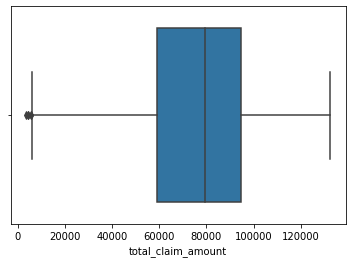

In [ ]:
sns.boxplot(b2)

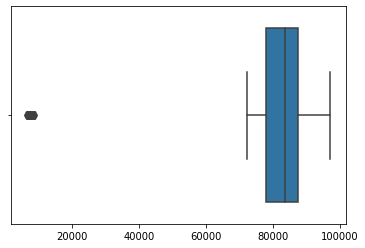

In [ ]:
sns.boxplot(pred)

## ***`XGBoost`*: DMatrix and Random Forest Regression**

In [ ]:
import xgboost as xgb
dtrain = xgb.DMatrix(a, label=b)
dval = xgb.DMatrix(a2, label=b2)

In [ ]:
params = {'colsample_bytree': 0.9,
 'eta': 0.05,
 'eval_metric': 'rmse',
 'learning_rate': 0.01,
 'max_depth': 9,
 'min_child_weight': 7,
 'objective': 'reg:squarederror',
 'reg_lambda': 0.5,
 'subsample': 0.7}

In [ ]:
params

{'colsample_bytree': 0.9,
 'eta': 0.05,
 'eval_metric': 'rmse',
 'learning_rate': 0.01,
 'max_depth': 9,
 'min_child_weight': 7,
 'objective': 'reg:squarederror',
 'reg_lambda': 0.5,
 'subsample': 0.7}

In [ ]:
super_reg = xgb.XGBRFRegressor
num_boost_round = 300

In [ ]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round = num_boost_round,
    evals=[(dval, "Val")],
    early_stopping_rounds=10
)
 
 
 
model2 = super_reg(
    #params,
    colsample_bytree =0.7,
    eta = 0.05,
    eval_metric = 'rmse',
    max_depth = 9,
    min_child_weight = 7,
    objective = 'reg:squarederror',
    subsample = 1.0,
    n_estimators = 10,
    num_boost_round = num_boost_round,
    evals = [(dval, "Val")],
    early_stopping_rounds = 10,
    reg_lambda = 0.5,
    random_state = 0)

[0]	Val-rmse:79147.6
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:78394.7
[2]	Val-rmse:77655.6
[3]	Val-rmse:76920.7
[4]	Val-rmse:76192.8
[5]	Val-rmse:75478
[6]	Val-rmse:74774.2
[7]	Val-rmse:74090
[8]	Val-rmse:73403.5
[9]	Val-rmse:72714.6
[10]	Val-rmse:72032.3
[11]	Val-rmse:71355.5
[12]	Val-rmse:70674.6
[13]	Val-rmse:70036.5
[14]	Val-rmse:69385.4
[15]	Val-rmse:68752.1
[16]	Val-rmse:68090.2
[17]	Val-rmse:67437.2
[18]	Val-rmse:66814.5
[19]	Val-rmse:66210.9
[20]	Val-rmse:65641.4
[21]	Val-rmse:65029.2
[22]	Val-rmse:64429.1
[23]	Val-rmse:63836.6
[24]	Val-rmse:63245.2
[25]	Val-rmse:62675
[26]	Val-rmse:62127
[27]	Val-rmse:61551.6
[28]	Val-rmse:61005
[29]	Val-rmse:60469.3
[30]	Val-rmse:59935.6
[31]	Val-rmse:59393.1
[32]	Val-rmse:58870.3
[33]	Val-rmse:58378
[34]	Val-rmse:57854.7
[35]	Val-rmse:57330.2
[36]	Val-rmse:56824
[37]	Val-rmse:56302.4
[38]	Val-rmse:55799.2
[39]	Val-rmse:55319.1
[40]	Val-rmse:54857.8
[41]	Val-rmse:54363.8
[42]	Val-rmse:53884.2
[43]	Val-rmse:53398.4


In [ ]:
dtest = xgb.DMatrix(a2)
#predictions = model.predict(dtest)
 
 
model2.fit(a,b)
predictions = model2.predict(a2)
 
 
predictions

array([80416.234 , 87277.234 , 87166.51  , 82748.32  , 83910.39  ,
       84879.47  , 88502.47  , 83973.58  , 85623.36  , 87173.87  ,
       86777.83  , 91834.92  , 14136.783 , 20880.406 , 79519.76  ,
       85599.72  , 82181.43  , 86777.83  , 85978.305 , 78968.11  ,
       76564.81  ,  8931.881 , 76746.67  , 84741.81  , 82859.05  ,
       85915.86  , 78109.46  ,  7729.694 , 15006.699 , 13955.751 ,
       80590.84  , 82436.84  ,  7767.9385, 81341.11  , 81930.69  ,
       80903.305 , 78400.125 , 84231.62  , 82967.09  , 79844.9   ,
       82337.12  , 84445.11  , 81231.59  , 79610.305 , 14852.187 ,
       85623.36  , 86458.88  , 79894.39  , 88717.58  , 81438.016 ,
       80086.63  , 84674.83  , 82406.164 , 15468.562 , 79722.984 ,
       80256.1   , 82870.11  , 79689.21  , 85212.16  , 85445.    ,
       75948.516 , 85623.36  , 86866.03  , 86866.03  , 84445.11  ,
       84464.46  ,  6976.523 , 81187.164 , 85212.16  , 87025.77  ,
       81496.805 , 76195.33  , 80256.1   , 80086.65  , 79663.8

In [ ]:
sqrt(MSE(b2, predictions))

18228.381895851853

###**Submission**

In [ ]:
submission = pd.DataFrame()
submission['Customer_ID'] = test['Customer_ID']
 
dsub = xgb.DMatrix(dx2)
#sub = model.predict(dsub)
sub = model2.predict(dx2)
 
submission['total_claim_amount'] = sub
submission.to_csv('submission.csv', index=False)
submission

,Customer_ID,total_claim_amount
0,Customer_521,84093.632812
1,Customer_737,80050.078125
2,Customer_740,82406.781250
3,Customer_660,84502.218750
4,Customer_411,13525.625000
...,...,...
295,Customer_468,75757.554688
296,Customer_935,83178.375000
297,Customer_428,77333.187500
298,Customer_7,86133.992188


In [ ]:
#Submission API
#!kaggle competitions submit -c data-science-nigeria-insurance-claims-competition -f submission.csv -m "Message"

100% 6.50k/6.50k [00:08<00:00, 822B/s]
Successfully submitted to Data Science Nigeria Insurance claims